# Мини-проект


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import statsmodels.api as sm
from matplotlib import pyplot as plt
from pylab import rcParams
from scipy import stats

Рассмотрим таблицу с данными о поездках желтых такси в Нью-Йорке, взятую с сайта https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
Далее будем изучать и предсказывать число поездок за каждый час.

In [2]:
data = pd.read_csv('data/2016-05.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


Для каждой поездки есть информация о времени и дате, широте и долготе ее начала и конца, числе пассажиров, расстоянии, оплате и пассажирах.
Данные о времени и дате имеют тип str, 'VendorID',RatecodeID, store_and_fwd_flag, payment_type - категориальные признаки, остальные вещественные.

Приведем время и дату к удобному формату, избавимся от поездок с нулевым расстоянием и посчитаем число заказов для каждого часа.

In [3]:
#data = data.head(500000)

In [4]:
data = data[data.trip_distance != 0]
data['pickup_datetime'] = pd.to_datetime(data.tpep_pickup_datetime)
data['dropoff_datetime'] = pd.to_datetime(data.tpep_dropoff_datetime)
data['pickup_hr'] = list(map(lambda x: x[:-6], data.tpep_pickup_datetime.values))

In [5]:
cols = ['passenger_count', 'trip_distance','fare_amount', 'tip_amount', 'total_amount']

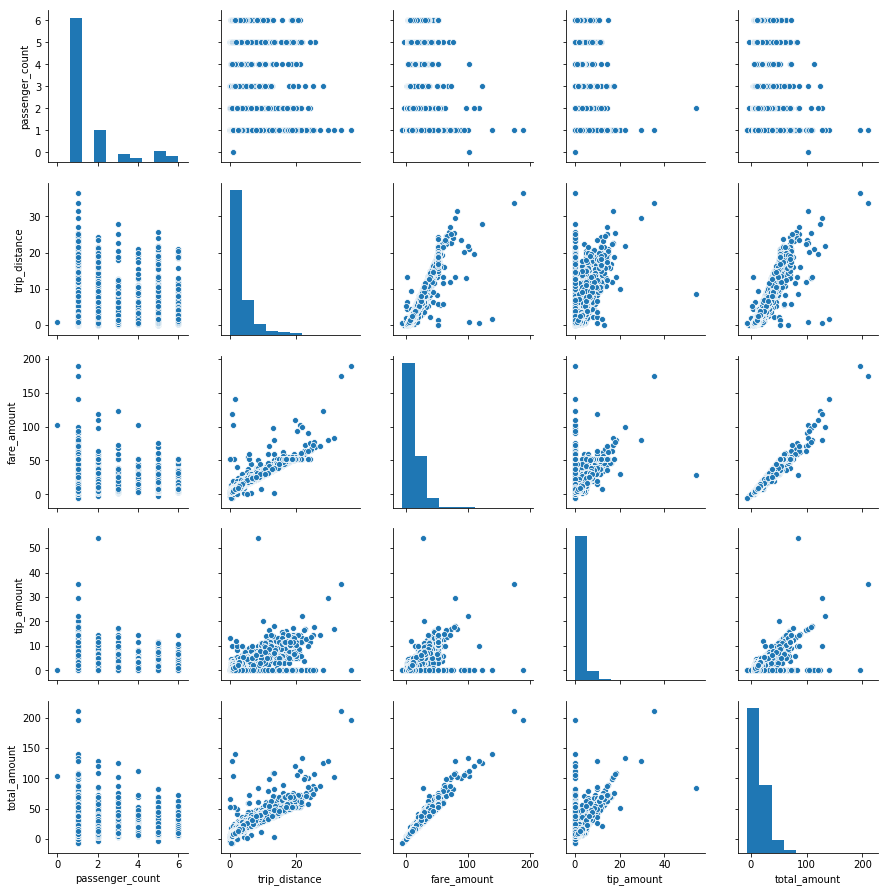

In [6]:
sns.pairplot(data[cols].head(10000))

Наблюдаем интуитивно верные зависимости: цена возрастает с ростом расстояния, чаевые увеличиваются с увеличением цены поездки, полная сумма очевидно слабо отличается в большую сторону от неполной суммы поездки.

Дальнейшая предобработка не требуется, так как будем использовать только число поездок, а не их характеристики.

Построим график временного ряда

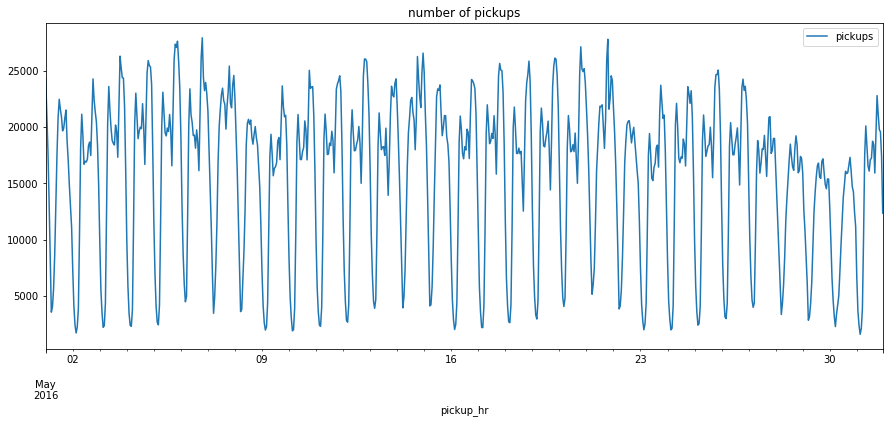

In [36]:
series = data.groupby('pickup_hr').count().VendorID
series = pd.DataFrame(series)
series['pickups'] = series.VendorID
series.drop('VendorID', axis=1, inplace=True)
series.index = pd.to_datetime(series.index) 
series.plot( figsize=(15,6), title='number of pickups')

Наблюдаем сезонность, явного тренда и циклов не видно. Проверим.

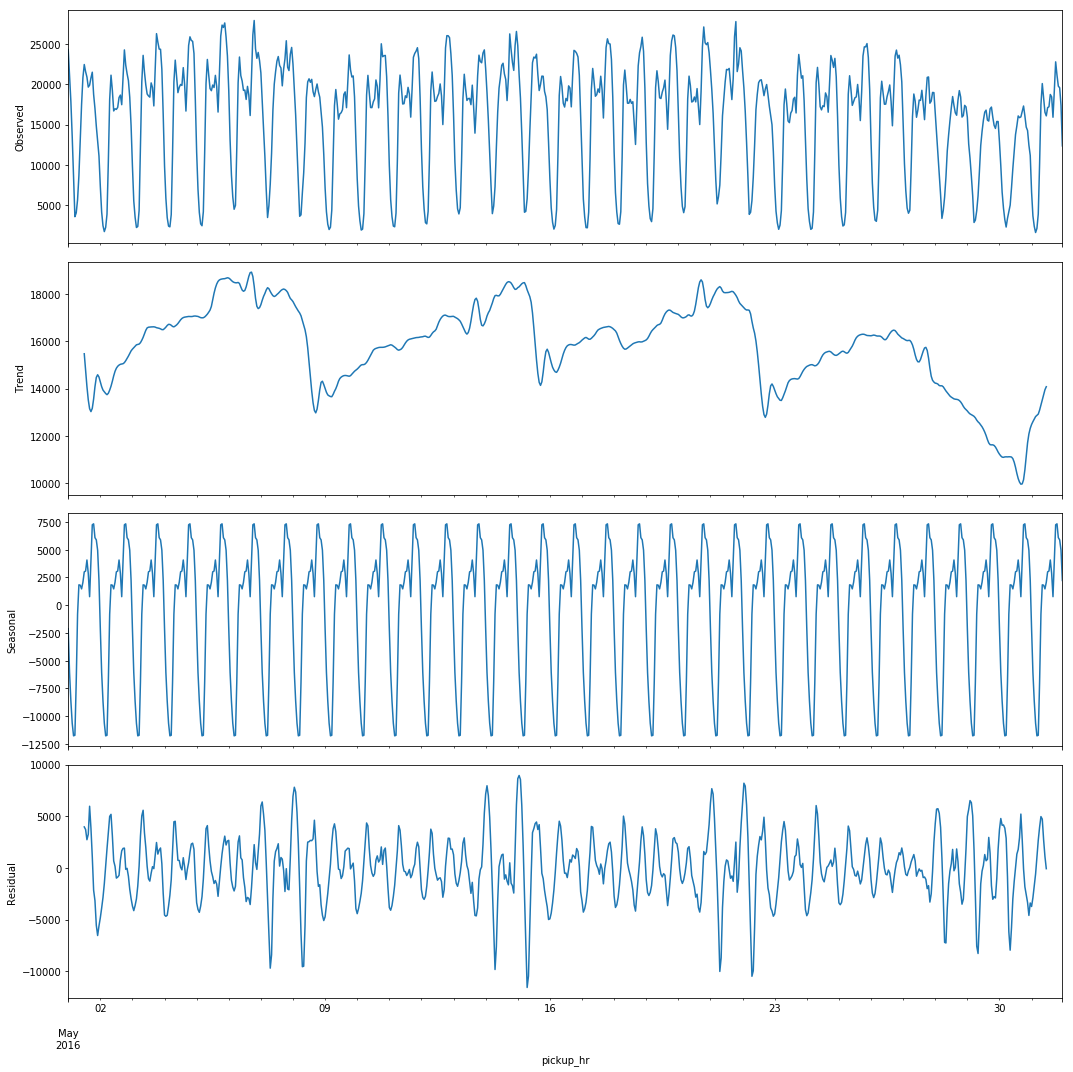

In [8]:
rcParams['figure.figsize'] = 15, 15
sm.tsa.seasonal_decompose(series).plot()
plt.show()

Проверим стационарность ряда по критерию Дики-Фуллера: Н0 - ряд не стационарен, Н1 - стационарен

In [9]:
print("Уровень значимости критерия Дики-Фуллера", sm.tsa.stattools.adfuller(series.pickups)[1])

Уровень значимости критерия Дики-Фуллера 0.0034253176420757335


Видим, что seasonal_decompose хорошо выделил дневную сезонность, но также есть и недельная, ряд стационарен по критерию Дики-Фуллера.

Проверим сначала распределение на нормальность. Воспользуемся критерием Шапиро-Уилка: Н0 - нормально, Н1 - не нормально.

In [10]:
print("Уровень значимости критерия Шапиро-Уилка",stats.shapiro(series.pickups)[1])

Уровень значимости критерия Шапиро-Уилка 5.057549316858856e-20


Данные действительно распределены не нормально, нужно пользоваться непараметрическими критериями. 

Проверим, отличаются ли среднее число вызовов за первую и последнюю неделю мая 2016 года. Будем использовать критерий Манна-Уитни: Н0 - среднее число поездок не изменилось, Н1 - изменилось

In [43]:
first = series[:"2016-05-07 23:59:59"].pickups
last = series["2016-05-23 23:59:59":].pickups

In [44]:
print("Не изменилось",stats.mannwhitneyu(last, first, alternative = 'two-sided')[1])
print("Уменьшилось",stats.mannwhitneyu(last, first, alternative = 'less')[1])

Не изменилось 7.904601795994996e-07
Уменьшилось 3.952300897997498e-07


Отвергается нулевая гипотеза, число поездок уменьшилось к концу месяца.
Полученные выводы логичны: число поездок сильно зависит от времени суток и от дня недели, явного тренда нет, в конце месяца снижение числа поездок может быть связано, например, с выдачей зарплаты.

Построим предсказание для временного ряда с помощью SARIMA. Для начала сделаем одно сезонное дифференцирование и одно обычное.

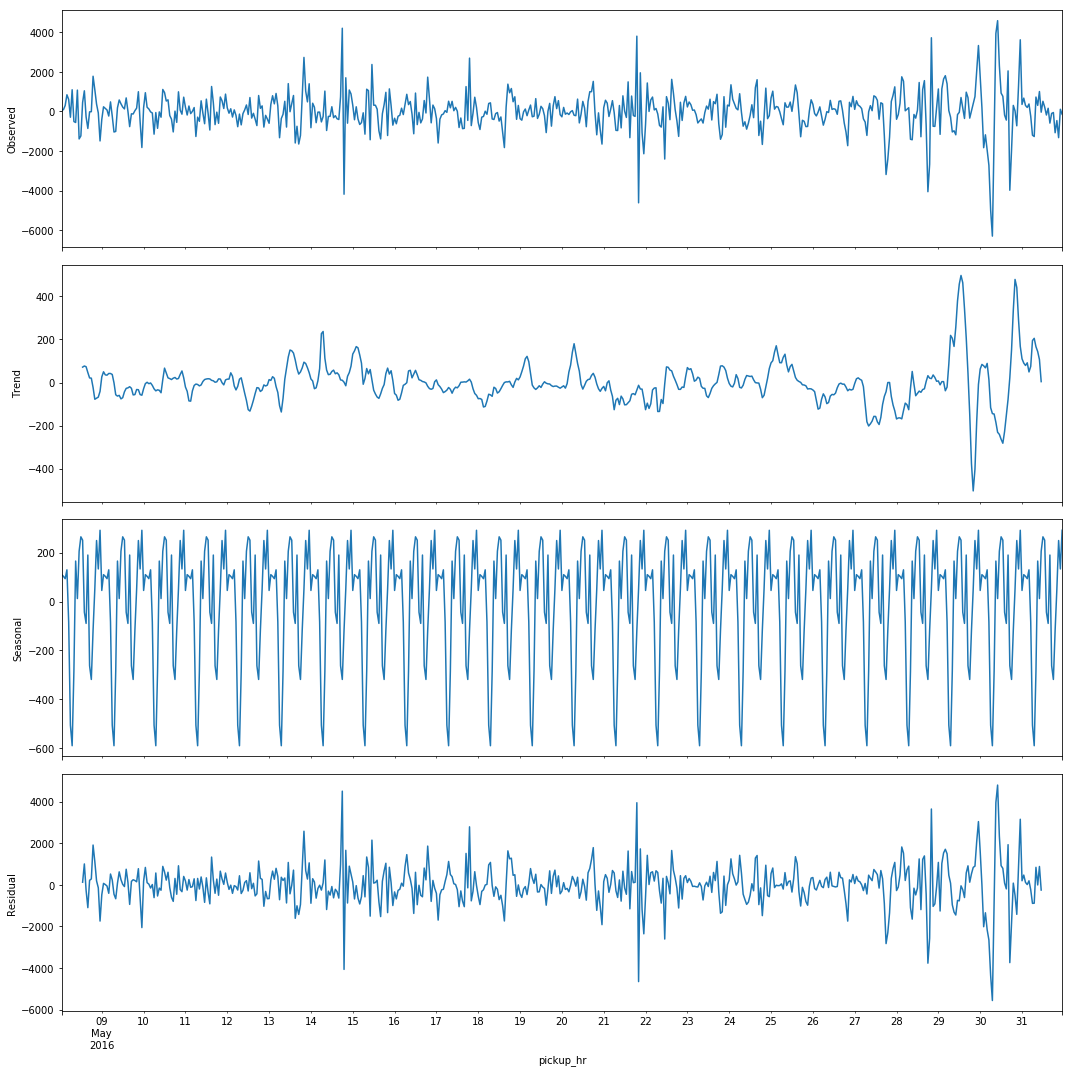

In [25]:
series['sdiff'] = series.pickups - series.pickups.shift(168)
series['diff_sdiff'] = (series.sdiff - series.sdiff.shift(1))[1:]
rcParams['figure.figsize'] = 15, 15
sm.tsa.seasonal_decompose(series['diff_sdiff'][169:]).plot()
plt.show()

lags=500


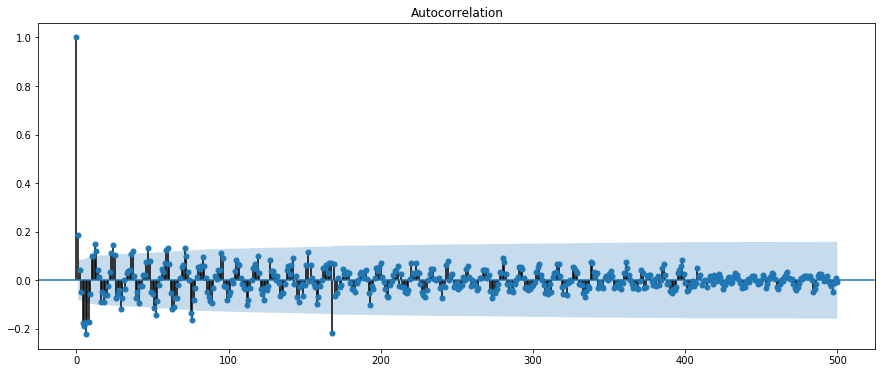

lags=50


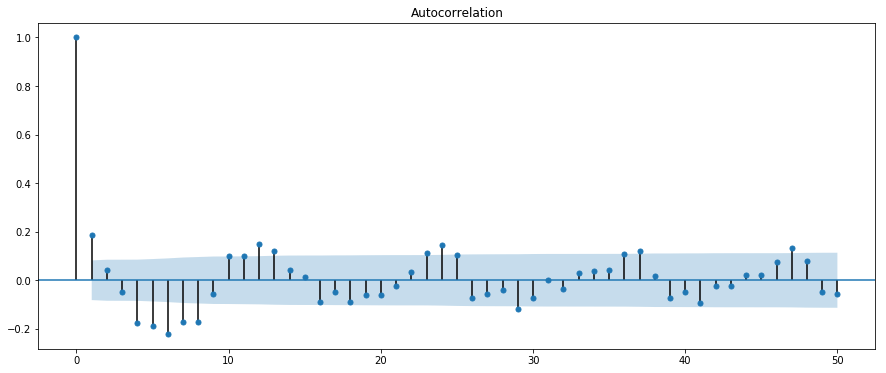

lags=20


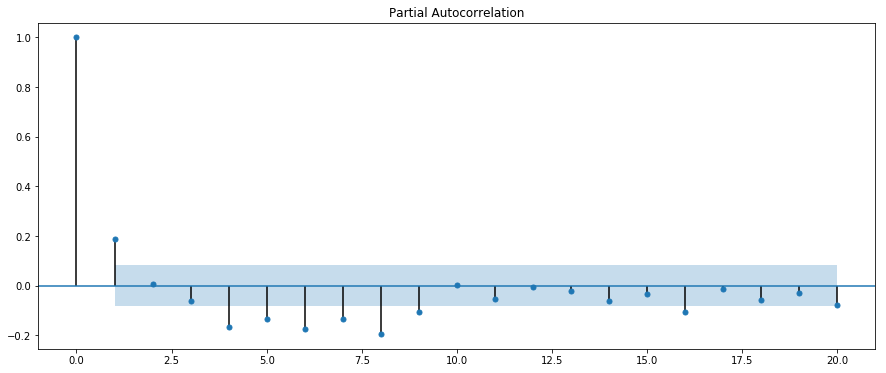

In [14]:
print('lags=500')
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(series.diff_sdiff[169:], lags=500,ax = ax)
plt.show()
print('lags=50')
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(series.diff_sdiff[169:], lags=50,ax = ax)
plt.show()
print('lags=20')
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_pacf(series.diff_sdiff[169:], lags=20,ax = ax)
plt.show()

In [29]:
from itertools import product
p = 8
ps = range(p+1)
P = 1
Ps = range(P+1)
q = 8
#qs = range(4,q+1)
qs = range(q+1)
Q = 0
Qs = range(Q+1)

d = 1
D = 1

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


162

In [31]:
%%time
import warnings
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(series.diff_sdiff, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
        print(param)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
(0, 0, 1, 0)
(0, 1, 0, 0)
(0, 1, 1, 0)
(0, 2, 0, 0)
(0, 2, 1, 0)
(0, 3, 0, 0)
(0, 3, 1, 0)
wrong parameters: (0, 4, 0, 0)
wrong parameters: (0, 4, 1, 0)
wrong parameters: (0, 5, 0, 0)
wrong parameters: (0, 5, 1, 0)
wrong parameters: (0, 6, 0, 0)
wrong parameters: (0, 6, 1, 0)
wrong parameters: (0, 7, 0, 0)
wrong parameters: (0, 7, 1, 0)
wrong parameters: (0, 8, 0, 0)
wrong parameters: (0, 8, 1, 0)
(1, 0, 0, 0)
(1, 0, 1, 0)
(1, 1, 0, 0)
(1, 1, 1, 0)
(1, 2, 0, 0)
(1, 2, 1, 0)
(1, 3, 0, 0)
(1, 3, 1, 0)
wrong parameters: (1, 4, 0, 0)
wrong parameters: (1, 4, 1, 0)
wrong parameters: (1, 5, 0, 0)
wrong parameters: (1, 5, 1, 0)
wrong parameters: (1, 6, 0, 0)
wrong parameters: (1, 6, 1, 0)
wrong parameters: (1, 7, 0, 0)
wrong parameters: (1, 7, 1, 0)
wrong parameters: (1, 8, 0, 0)
wrong parameters: (1, 8, 1, 0)
(2, 0, 0, 0)
(2, 0, 1, 0)
(2, 1, 0, 0)
(2, 1, 1, 0)
(2, 2, 0, 0)
(2, 2, 1, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 4, 0, 0)
w

In [32]:
best_param

(8, 1, 1, 0)

In [33]:
print(best_model.summary().tables[0])
print(best_model.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                         diff_sdiff   No. Observations:                  744
Model:             SARIMAX(8, 1, 1)x(1, 1, 0, 24)   Log Likelihood               -4862.083
Date:                            Sat, 18 May 2019   AIC                           9746.166
Time:                                    20:28:07   BIC                           9796.522
Sample:                                05-01-2016   HQIC                          9765.608
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0440      0.025      1.782      0.075      -0.004       0.092
ar.L2         -0.0081      0.033   

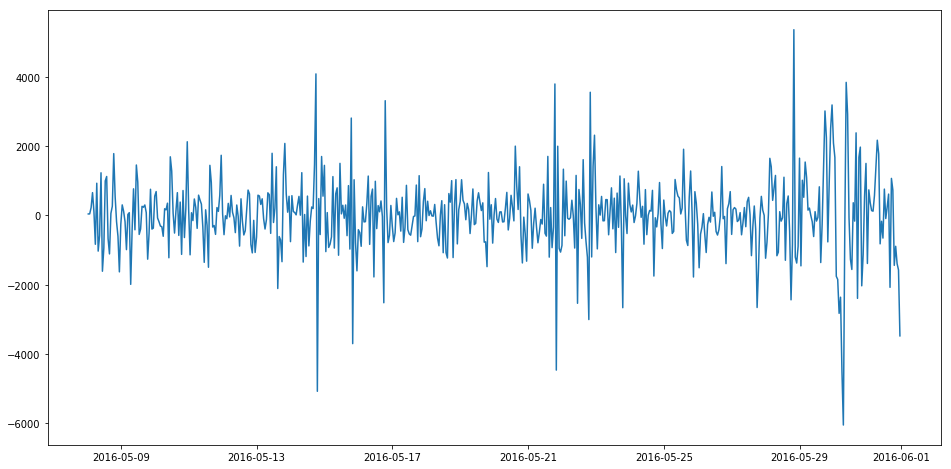

In [34]:
# Остатки модели похожи на белый шум, возможно, есть неочевидные циклы
plt.figure(figsize=(16,8))
plt.plot(best_model.resid[1:])
plt.show()

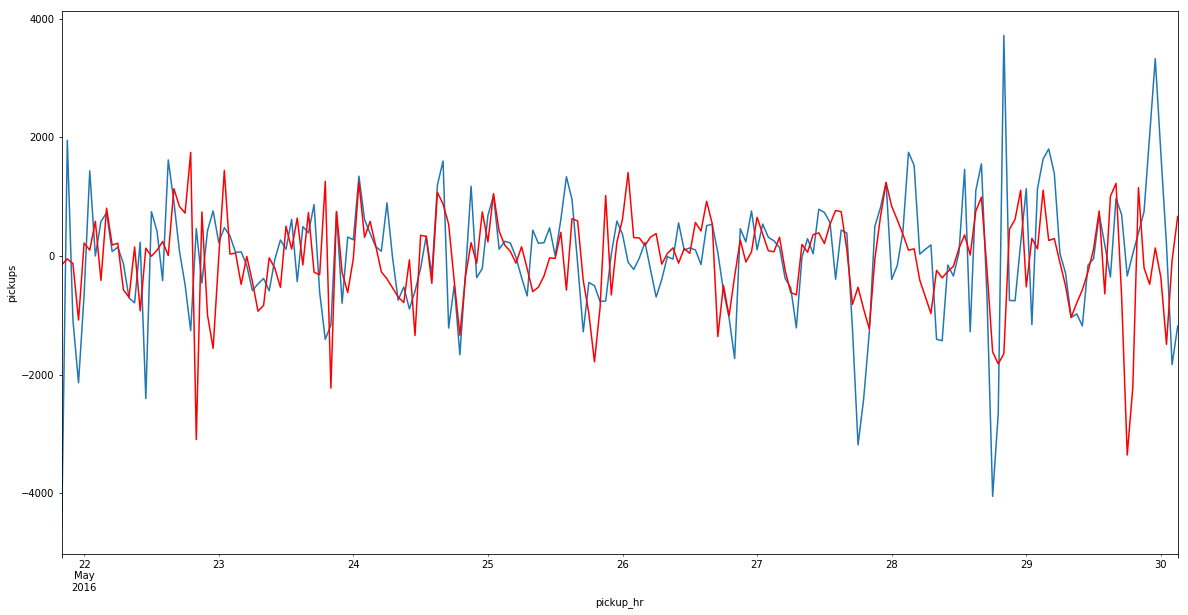

In [35]:
plt.figure(figsize=(20,10))
series.diff_sdiff[500:700].plot()
best_model.fittedvalues[500:700].plot(color='r')
plt.ylabel('pickups')
plt.show()

Построен относительно точный прогноз, возможно, точность увеличится с увеличением объема данных. 